# Lab2 - Point-of-Interest Recommendation Systems
## Urban Computing course - Leiden University
#### Instructor: Dr. Mitra Baratchi
#### Contributor: Hossein A. Rahmani





## Outline

1.   Recommender systems and Context information
2.   General Structure of Location-Based Social Network's Dataset
3.   Loading the dataset (Foursquare)
4.   Data Pre-processing
5.   Matrix Factorization
6.   Model Evaluation
7.   Utilizing Contextual Information: Geographical Model

## Recommender Systems

Recommender systems (RSs) aim to predict the most relevant items to a user. RSs are a subclass of **information filtering systems** addressing the problem of information overload. An example of a recommendation system in action is when you visit Youtube website and you notice that some movies are being recommended to you. One of the most important applications of recommender systems is in Location-Based Social Networks (LBSNs) to recommend unvisited Point-of-Interests (POIs) to users.

### Recommender system approaches

Recommender System approaches are generally divided into three categories:

- **Collaborative Filtering (CF)**: CF methods recommend items to users using their past behavior or their ratings on items, as well as, similar decisions made by other similar users. The CF methods are further divided into two subcategories, __Memory-based__ and __Model-based__. In this lab, we compare two methods selected from each of these two groups.

- **Content-Based (CB)**: CB methods recommend items to users using the characteristics (or known features) of an item, aiming to find other items with similar properties.

- **Hybrid Method**: A number of applications combine CF and CB algorithms. Using this combinatory approach they aim to overcome the limitations of native CF and CB approaches and improve prediction performance. Importantly, they overcome the CF problems such as sparsity and loss of information. 

Collaborative filtering is much more popular for recommendations where the data is sparse, i.e., where there is a limited number of interactions by each user or for a particular item.

More information for study and comparison can be find in the [Basics of Recommender Systems: Study of Location-Based Social Networks](https://github.com/rahmanidashti/LRSbasics).

### Context-Aware Recommender Systems

In many applications, such as recommending a location, it may not be sufficient to consider only users and items – it is also important to incorporate **contextual information** into the recommendation process in order to recommend items to users in certain time, or location. For example, using the temporal context, a location recommender system would provide a POI recommendation in the afternoon that can be very different from the one in night. In addition, geographical influence is an important contextual factor that distinguishes the location recommendation from traditional item recommendation, because the check-in behavior depends on locations’ geographical features. The users' behavior on location-based social networks shows they would like to visit nearby locations rather than the distant ones.

## LBSN's Dataset

The dataset of a LBSN is generated based on the feature of registering __Check-in__s. A user can check in a location, to register his/her presence in that location. Generally, a check-in record includes the following:

*   UserID
*   LocationID
*   Latitude and longitude of a location
*   Check-in time

For example, a record of check-in can be: **user_0, location_0, 1.372494548, 103.893714, 28-01-2019 14:17:15**



## Import the required module

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import scipy.sparse as sparse
from collections import defaultdict
import time
import math
from scipy.stats import multivariate_normal
# data visualization
import matplotlib.pyplot as plt
# data visualization
import folium

## Load the dataset
To access the dataset, we have uploaded the preprocessed dataset of Gowalla [1] LBSN into a Github repository. Here, we have four files that are needed for this assignment: **size, train, test, and geo**. The _size_ file includes the number of users and location (or POIs), _train and test_ files store the user's check-ins and the _geo_ file includes the geographical information of each location. As mentioned above, we load the dataset from Github. This is a small version of Gowalla dataset. You can find other versions (such as Gowalla, Foursquare, or Yelp [1]). Some examples are available in the following repository to evaluate the methods https://github.com/rahmanidashti/LBSNDatasets/).

In [2]:
size = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_data_size.txt"
train = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_train.txt"
test = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_test.txt"
geo = "https://raw.githubusercontent.com/rahmanidashti/LBSNDatasets/master/Gowalla/Gowalla_2/Gowalla_poi_coos.txt"

In [3]:
""" read the datasets as CSV files """

size_header = ['users', 'locations']
size_data = pd.read_csv(size, sep='	', names=size_header)
for index, eachline in size_data.iterrows():
  n_users, n_locations = eachline['users'], eachline['locations']
print("The numebr of users is", n_users,"and the number of locations is", n_locations)

header = ['uid', 'lid', 'freq']
train_data = pd.read_csv(train, sep='	', names=header)
test_data = pd.read_csv(test, sep='	', names=header)

geo_header = ['lid', 'lat', 'lng']
poi_data = pd.read_csv(geo, sep='	', names=geo_header)

The numebr of users is 100 and the number of locations is 6436


### Load the training data

In [4]:
def read_training_data():
  training_matrix = np.zeros((n_users, n_locations))
  sparse_training_matrix = sparse.dok_matrix((n_users, n_locations))
  for index, row in train_data.iterrows():
    uid, lid, freq = row['uid'], row['lid'], row['freq']
    uid, lid, freq = int(uid), int(lid), int(freq)
    training_matrix[uid, lid] = 1.0
    sparse_training_matrix[uid, lid] = freq
  return sparse_training_matrix, training_matrix

### Load the latitude and longitude of POIs

In [5]:
def read_poi_coos():
  poi_coos = {}
  for index, row in poi_data.iterrows():
    lid, lat, lng = row['lid'], row['lat'], row['lng']
    lid, lat, lng = int(lid), float(lat), float(lng)
    poi_coos[lid] = (lat, lng)
  return poi_coos

### Load the test data

A part of dataset should be reserved for testing. Here, we consider 20% of recently available check-ins as test set.

In [6]:
def read_ground_truth():
  ground_truth = defaultdict(set)
  for index, row in test_data.iterrows():
    uid, lid, _ = row['uid'], row['lid'], row['freq']
    uid, lid = int(uid), int(lid)
    ground_truth[uid].add(lid)
  return ground_truth

### Intialize the datasets

In [7]:
sparse_training_matrix, training_matrix = read_training_data()
ground_truth = read_ground_truth()
poi_coos = read_poi_coos()

## Collaborative Filtering
As mentioned earlier, one of the most popular approaches for recommendation is __Collaborative Filtering (CF)__. The user-based approach is suitable for small datasets. When you need scalability, often MF or other model-based approaches perfrom better. Hence, we first consider and implement the user-based CF to recommend POIs. Next, we implement one of the MF-based approaches. Finally, we show the impact of context in RS and integrate one of the most important contextual factors in location recommendation to the MF model.

### User-Based Collaborative Filtering [2]
 A user-based system uses machine-learning algorithms to group all users who have shown to have similar tastes. The system builds neighborhoods of users who have similar profiles, or rating patterns. The recommender system can recommend an item to everyone if a person in his/her neighborhood buys and likes that item. Here, we used __cosine-based similarity__. The cosine-based approach defines the cosine-similarity between two users $x$ and $y$ as:
 
 $\operatorname {sim} (x,y)=\cos({\vec {x}},{\vec {y}})={\frac {{\vec {x}}\cdot {\vec {y}}}{||{\vec {x}}||\times ||{\vec {y}}||}}={\frac {\sum \limits _{i\in I_{xy}}r_{x,i}r_{y,i}}{{\sqrt {\sum \limits _{i\in I_{x}}r_{x,i}^{2}}}{\sqrt {\sum \limits _{i\in I_{y}}r_{y,i}^{2}}}}}$

In [8]:
class UserBasedCF(object):
  def __init__(self):
    self.rec_score = None
    self.epsilon = 1e-9
  
  """ This function compute the scores of the users on different POIs based on
  the User-based and Cosine similarity """
  
  def pre_compute_rec_scores(self, C):
    ctime = time.time()
    print("Training User-based Collaborative Filtering...", )

    sim = C.dot(C.T)
    norms = [norm(C[i]) for i in range(C.shape[0])]

    for i in range(C.shape[0]):
      sim[i][i] = 0.0
      for j in range(i+1, C.shape[0]):
        sim[i][j] = sim[i][j] / ((norms[i] * norms[j]) + self.epsilon)
        sim[j][i] = sim[i][j] / ((norms[i] * norms[j]) + self.epsilon)

    self.rec_score = sim.dot(C)
    print("Done. Elapsed time:", time.time() - ctime, "s")

  # return the predicted value
  def predict(self, i, j):
    return self.rec_score[i][j]


## Evaluation process of recommendation (Precision and Recall)

Precision and recall are two commonly used metrics for evaluating the performance of recommender systems. Precision is defined as a fraction of relevant instances among the retrieved instances, while recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances. You can read more on [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall).

In [9]:
# calculate the precision
def precisionk(actual, predicted):
  return 1.0 * len(set(actual) & set(predicted)) / len(predicted)

In [10]:
# calculate the recall
def recallk(actual, predicted):
  return 1.0 * len(set(actual) & set(predicted)) / len(actual)

## Store the evaluation values

In order to store the results of the experiment we have defined a number of variables (as [list](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists)).

In [11]:
# precison and recall by user-based CF for each user
precision_UB, recall_UB = [], []
# precison and recall by Poisson Matrix Factorization Matrix Factorization for each user
precision_MF, recall_MF = [], []
# precison and recall by MF + Geographical Influence for each user
precision_MFG, recall_MFG = [], []

### Recommendation by User-based Collaborative Filtering

In [12]:
def ub_runer():
  top_k = 100
  
  # remove the last values from pre and rec
  del precision_UB[:]
  del recall_UB[:]
  
  U = UserBasedCF()
  
  # Compute the user-based CF
  U.pre_compute_rec_scores(training_matrix)
  
  all_uids = list(range(n_users))
  all_lids = list(range(n_locations))
  np.random.shuffle(all_uids)
  
  # calculate the prediction value for each user on different items
  for cnt, uid in enumerate(all_uids):   
    if uid in ground_truth:
      U_scores = [U.predict(uid, lid)
                  if training_matrix[uid, lid] == 0 else -1
                  for lid in all_lids]
      
      U_scores = np.array(U_scores)
      
      # sort the items based on their prediction value
      predicted = list(reversed(U_scores.argsort()))[:top_k]
      actual = ground_truth[uid]
      
      # compute each user's precision and recall
      precision_UB.append(precisionk(actual, predicted[:10]))     
      recall_UB.append(recallk(actual, predicted[:10]))
      
  print("pre@10:", np.mean(precision_UB), "rec@10:", np.mean(recall_UB))    

In [13]:
# Now, you can run the user-based CF
ub_runer()

Training User-based Collaborative Filtering...
Done. Elapsed time: 0.21466422080993652 s
pre@10: 0.045 rec@10: 0.029128869480040426


## Matrix Factorization (MF)
Another technique commonly used for these types of problems is matrix factorization. The idea of this method is to take the original visit count matrix, and then decompose it to two much smaller matrices that approximate the original matrix when multiplied together. You can find more about MF in [quuxlbs blog post](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/). Here, based on [2], we use a version of matrix factorization called __Poisson Factor Model__. 

### Matrix Factorization: Poisson Factor Model [3]

In [14]:
class PoissonFactorModel(object):
  def __init__(self, K=30, alpha=20.0, beta=0.2):
    self.K = K
    self.alpha = alpha
    self.beta = beta
    self.U, self.L = None, None

  def train(self, sparse_check_in_matrix, max_iters=50, learning_rate=1e-4):
    ctime = time.time()
    print("Training PFM...", )

    alpha = self.alpha
    beta = self.beta
    K = self.K

    F = sparse_check_in_matrix
    M, N = sparse_check_in_matrix.shape
    
    # initialize the vectors randomly
    U = 0.5 * np.sqrt(np.random.gamma(alpha, beta, (M, K))) / K
    L = 0.5 * np.sqrt(np.random.gamma(alpha, beta, (N, K))) / K

    F = F.tocoo()
    entry_index = list(zip(F.row, F.col))

    F = F.tocsr()
    F_dok = F.todok()

    tau = 10
    last_loss = float('Inf')
    for iters in range(max_iters):
      F_Y = F_dok.copy()
      for i, j in entry_index:
        F_Y[i, j] = 1.0 * F_dok[i, j] / U[i].dot(L[j]) - 1
      F_Y = F_Y.tocsr()

      learning_rate_k = learning_rate * tau / (tau + iters)
      
      # update the user and location (POI) vector
      U += learning_rate_k * (F_Y.dot(L) + (alpha - 1) / U - 1 / beta)
      L += learning_rate_k * ((F_Y.T).dot(U) + (alpha - 1) / L - 1 / beta)

      loss = 0.0
      for i, j in entry_index:
        loss += (F_dok[i, j] - U[i].dot(L[j]))**2

      print('Iteration:', iters,  'loss:', loss)

      if loss > last_loss:
        print("Early termination.")
        break
        last_loss = loss

      print("Done. Elapsed time:", time.time() - ctime, "s")
      self.U, self.L = U, L
      
  # return the predicted value (inner product of vectors)
  def predict(self, uid, lid):
    return self.U[uid].dot(self.L[lid])

### Recommendation by the Matrix Factoriztion

In [15]:
# This function is similar to the ub_runer() function

def mf_runer():
  
  top_k = 100
  
  del precision_MF[:]
  del recall_MF[:]
  
  
  PFM = PoissonFactorModel(K=30, alpha=20.0, beta=0.2)
  PFM.train(sparse_training_matrix, max_iters=10, learning_rate=1e-4)
  
  all_uids = list(range(n_users))
  all_lids = list(range(n_locations))
  np.random.shuffle(all_uids)
    
  for cnt, uid in enumerate(all_uids):
    if (int(cnt) != 0 and int(cnt) % 100 == 0):
      print("Passed", int(cnt), "/", n_users, "by Precision@10 and Recall@10: ",  np.mean(precision_MF), "and", np.mean(recall_MF))
    if uid in ground_truth:
      overall_scores = [PFM.predict(uid, lid)
                        if training_matrix[uid, lid] == 0 else -1
                        for lid in all_lids]     
      
      overall_scores = np.array(overall_scores)

      predicted = list(reversed(overall_scores.argsort()))[:top_k]
      actual = ground_truth[uid]
      
      precision_MF.append(precisionk(actual, predicted[:10]))
      recall_MF.append(recallk(actual, predicted[:10]))
      
  print(">> Finally Precision@10:", np.mean(precision_MF), "Recall@10:", np.mean(recall_MF))

In [16]:
mf_runer()

Training PFM...
Iteration: 0 loss: 153804.6466924741
Done. Elapsed time: 0.45594191551208496 s
Iteration: 1 loss: 150392.2329277504
Done. Elapsed time: 0.8984389305114746 s
Iteration: 2 loss: 147679.71908446436
Done. Elapsed time: 1.3494558334350586 s
Iteration: 3 loss: 145458.23821262922
Done. Elapsed time: 1.7642900943756104 s
Iteration: 4 loss: 143608.63690096192
Done. Elapsed time: 2.1822099685668945 s
Iteration: 5 loss: 142051.464637633
Done. Elapsed time: 2.699350118637085 s
Iteration: 6 loss: 140729.79860856428
Done. Elapsed time: 3.17022705078125 s
Iteration: 7 loss: 139601.10535289926
Done. Elapsed time: 3.600219964981079 s
Iteration: 8 loss: 138632.6859252523
Done. Elapsed time: 4.003270864486694 s
Iteration: 9 loss: 137798.8645074791
Done. Elapsed time: 4.416164875030518 s
>> Finally Precision@10: 0.027000000000000003 Recall@10: 0.01745983366975592


## Context Information

One of the most important context information for location-based recommendation is geographical information. Geographical (or _spatial_) information allows us to focus recommendations on locations close to the user, keeping our recommendations relevant as a user travels. Users tend to check-in around several centers, where the check-in locations follow a Gaussian distribution at each center. The following code segment shows that a typical user’s check-in behavior appear around a number of centers.

In [17]:
# which user's check-ins distribution want to show?
which_user = 0

locationlist = []
# get the locations that have been checked-in by which_user
for user_checkins in range(training_matrix.shape[0]):
  if user_checkins == which_user:
    locations = training_matrix[user_checkins].nonzero()
  break
  
for locs in locations:
  for loc in locs:
    lat, lng = poi_coos[loc]
    # Make a list with the coordinates of each location
    locationlist.append([lat, lng])

# Open a map and initialize it with the coordinates
map = folium.Map(location=locationlist[0], zoom_start=5)
# add to the map all different locations
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map

### Geographical Information: Multi-center Gaussian Model [3]

Here, we consider the geographical influence based on the idea mentioned above. Then, we fuse the geographical influence into our MF method to show the impact of contextual information.

#### Find the distance between to location points

In [18]:
# Calculate the distnace between two given POIs or locations
def dist(loc1, loc2):
    lat1, long1 = loc1.lat, loc1.lng
    lat2, long2 = loc2.lat, loc2.lng
    if abs(lat1 - lat2) < 1e-6 and abs(long1 - long2) < 1e-6:
        return 0.0
    degrees_to_radians = math.pi/180.0
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) +
           math.cos(phi1)*math.cos(phi2))
    arc = math.acos(cos)
    earth_radius = 6371
    return arc * earth_radius

#### The geographical approach
The final score by Multi-center Gaussian Model is calculated according to the following equation:

$P(l|C_u)=\sum_{c_u=1}^{|C_u|}P(l\in{C_u})\frac{f_{c_u}^{\alpha}}{\sum_{i\in{C_u}}f_{i}^{\alpha}}\frac{N(l|\mu_{c_u},\sum_{c_u})}{\sum_{i\in{C_u}}N(l|\mu_{i},\sum_{i})}$ (Eq 1. in [3])

In [19]:
class Location(object):
    def __init__(self, id, lat, lng, freq, center=-1):
        self.id = id
        self.lat = lat
        self.lng = lng
        self.freq = freq
        self.center = center


class Center(object):
    def __init__(self):
        self.locations = []
        self.total_freq = 0
        self.distribution = None
        self.mu = None
        self.cov = None
        self.lat = None
        self.lng = None

    def add(self, loc):
        self.locations.append(loc)
        self.total_freq += loc.freq

    def build_gaussian(self):
        coo_seq = []
        for loc in self.locations:
            for _ in range(int(loc.freq)):
                coo_seq.append(np.array([loc.lat, loc.lng]))
        coo_seq = np.array(coo_seq)
        self.mu = np.mean(coo_seq, axis=0)
        self.cov = np.cov(coo_seq.T)
        self.distribution = multivariate_normal(self.mu, self.cov, allow_singular=True)
        self.lat = self.mu[0]
        self.lng = self.mu[1]

    def pdf(self, x):
        return self.distribution.pdf(np.array([x.lat, x.lng]))


class MultiGaussianModel(object):
    def __init__(self, alpha=0.2, theta=0.02, dmax=15):
        self.alpha = alpha
        self.theta = theta
        self.dmax = dmax
        self.poi_coos = None
        self.center_list = None

    def build_user_check_in_profile(self, sparse_check_in_matrix):
        L = defaultdict(list)
        for (uid, lid), freq in sparse_check_in_matrix.items():
            lat, lng = self.poi_coos[lid]
            L[uid].append(Location(lid, lat, lng, freq))
        return L

    # Find the centers of each users based on the Algorithm 1 in [2]  
    def discover_user_centers(self, Lu):
        center_min_freq = max(sum([loc.freq for loc in Lu]) * self.theta, 2)
        Lu.sort(key=lambda k: k.freq, reverse=True)
        center_list = []
        center_num = 0
        for i in range(len(Lu)):
            if Lu[i].center == -1:
                center_num += 1
                center = Center()
                center.add(Lu[i])
                Lu[i].center = center_num
                for j in range(i+1, len(Lu)):
                    if Lu[j].center == -1 and dist(Lu[i], Lu[j]) <= self.dmax:
                        Lu[j].center = center_num
                        center.add(Lu[j])
                if center.total_freq >= center_min_freq:
                    center_list.append(center)
        return center_list

    # calculate the gussain for the related POI at each center
    def multi_center_discovering(self, sparse_check_in_matrix, poi_coos):
        self.poi_coos = poi_coos
        L = self.build_user_check_in_profile(sparse_check_in_matrix)

        center_list = {}
        for uid in range(len(L)):
            center_list[uid] = self.discover_user_centers(L[uid])
            for cid in range(len(center_list[uid])):
                center_list[uid][cid].build_gaussian()
        self.center_list = center_list

    # Return the calculated value as the score    
    def predict(self, uid, lid):
        lat, lng = self.poi_coos[lid]
        l = Location(None, lat, lng, None)

        prob = 0.0
        if uid in self.center_list:
            all_center_freq = sum([cid.total_freq**self.alpha for cid in self.center_list[uid]])
            all_center_pdf = sum([cid.pdf(l) for cid in self.center_list[uid]])
            if not all_center_pdf == 0:
                for cu in self.center_list[uid]:
                    prob += (
                        1.0 / (dist(l, cu) + 1) *
                        (cu.total_freq**self.alpha) / all_center_freq *
                        cu.pdf(l) / all_center_pdf)
        return prob

### Run the Matrix Factorization with Multi-Center Geographical Model [3] (MFG)
For this purpose, the MF method will be fused with the MGM model. The final recommendation score is $P_{ul}=P(F_{ul}).P(l|C_u)$ where $P(F_{ul})$ is acquired from MF and $P(l|C_u)$ is acquired from MGM.

In [20]:
def mfg_runer():
  
  top_k = 100
  
  del precision_MFG[:]
  del recall_MFG[:]
  
  PFM = PoissonFactorModel(K=30, alpha=20.0, beta=0.2)
  PFM.train(sparse_training_matrix, max_iters=10, learning_rate=1e-4)
  
  print("Starting Multi-Center Gaussian Model ...")
  MGM = MultiGaussianModel(alpha=0.2, theta=0.02, dmax=15)
  MGM.multi_center_discovering(sparse_training_matrix, poi_coos)
  print("Done Multi-Center Gaussian Model.")
  
  all_uids = list(range(n_users))
  all_lids = list(range(n_locations))
  np.random.shuffle(all_uids)
    
  for cnt, uid in enumerate(all_uids):
    if (int(cnt) != 0 and int(cnt) % 100 == 0):
      print("Passed", int(cnt), "/", n_users, "by Precision@10 and Recall@10: ",  np.mean(precision_MFG), "and", np.mean(recall_MFG))
    if uid in ground_truth:
      overall_scores = [PFM.predict(uid, lid) * MGM.predict(uid, lid)
                        if training_matrix[uid, lid] == 0 else -1
                        for lid in all_lids]     
      
      overall_scores = np.array(overall_scores)

      predicted = list(reversed(overall_scores.argsort()))[:top_k]
      actual = ground_truth[uid]
      
      precision_MFG.append(precisionk(actual, predicted[:10]))
      recall_MFG.append(recallk(actual, predicted[:10]))
      
  print(">> Finally Precision@10:", np.mean(precision_MFG), "Recall@10:", np.mean(recall_MFG))   

In [21]:
mfg_runer()

Training PFM...
Iteration: 0 loss: 153756.9340099095
Done. Elapsed time: 0.42464518547058105 s
Iteration: 1 loss: 150345.6249388786
Done. Elapsed time: 0.8175218105316162 s
Iteration: 2 loss: 147633.7291258644
Done. Elapsed time: 1.2159099578857422 s
Iteration: 3 loss: 145412.73761428182
Done. Elapsed time: 1.640434980392456 s
Iteration: 4 loss: 143563.5865373208
Done. Elapsed time: 2.0435080528259277 s
Iteration: 5 loss: 142006.85345896395
Done. Elapsed time: 2.4830880165100098 s
Iteration: 6 loss: 140685.62480364006
Done. Elapsed time: 2.8502211570739746 s
Iteration: 7 loss: 139557.36970378723
Done. Elapsed time: 3.253411054611206 s
Iteration: 8 loss: 138589.38933528026
Done. Elapsed time: 3.678169012069702 s
Iteration: 9 loss: 137756.00711654316
Done. Elapsed time: 4.069010972976685 s
Starting Multi-Center Gaussian Model ...
Done Multi-Center Gaussian Model.
>> Finally Precision@10: 0.042 Recall@10: 0.0269395778054627


## Expriment Comparsion

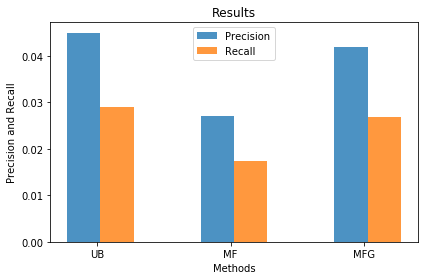

In [22]:
# data to plot
n_groups = 3
means_precision = (np.mean(precision_UB), np.mean(precision_MF), np.mean(precision_MFG))
means_recall = (np.mean(recall_UB), np.mean(recall_MF), np.mean(recall_MFG))

 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_precision, bar_width,
alpha=opacity,
label='Precision')
 
rects2 = plt.bar(index + bar_width, means_recall, bar_width,
alpha=opacity,
label='Recall')
 
plt.xlabel('Methods')
plt.ylabel('Precision and Recall')
plt.title('Results')
plt.xticks(index + 0.1, ('UB', 'MF', 'MFG'))
plt.legend()
 
plt.tight_layout()
plt.show()

### Significance of the results
The bar chart above compares the result of recommendation based on a User-Based (UB) approach, Matrix Factorization (MF), and Matrix Factorization with geographical influence (MFG). You already see some differences in the bar charts above. However, to show whether the difference achieved in the results is significant or not (i.e. there is a significant difference between the means of two distributions) you can use the _t-Test_. For this purpose, you need to run _t-Test_ for each result based on each metric. You can find more details in the following link and see how to use _t-Test_ in python with Scipy: [t-Test in Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

### Conclusion
As you can see in the plot that the UB method is outperforming other methods. Not achieving better performance form MF-based methods can be due to the inadequate size of the dataset used. Here, the size of the dataset is very small (100 users). The _user-based_ approach uses all of the users' and items' information.  When the number of users and items grow, the MF approaches will show their performance gain better. Furthermore, you can see that MFG is outperforming MF. This shows the impact of context information in modeling users' behavior.

## Acknowledgement
For implemenation we got some information and inspiration of the codes that provided by the following paper:  
__ [1] Liu, Yiding, et al. "An experimental evaluation of point-of-interest recommendation in location-based social networks." in VLDB, 2017__

## References

__ [2] Ye, Mao, et al. "Exploiting geographical influence for collaborative point-of-interest recommendation" in SIGIR, 2011.__  
__ [3] Cheng, Chen, et al. "Fused matrix factorization with geographical and social influence in location-based social networks", in AAAI, 2012.__